# 1. Data Cleaning

### Import neccessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Libraries for Reinforcement Learning

In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from gymnasium import spaces

In [7]:
# !pip install "gymnasium[all]"
# !pip install torch
# !pip install stable-baselines3

### Load the dataset

In [9]:
file_path = "diabetes.csv"  # Change this to the correct path if needed
df = pd.read_csv(file_path)

### Display basic information about the dataset

In [11]:
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Display the first few rows

In [13]:
print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


### Store column names

In [15]:
data_columns = df.columns
data_columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Handle null values

In [17]:
missing_values_count = df.isnull().sum()
missing_values_count

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No null cell, so no need cleaning

### Handle duplicate rows

In [20]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


No duplicate rows, so no need cleaning

# 2. Visualising the data 

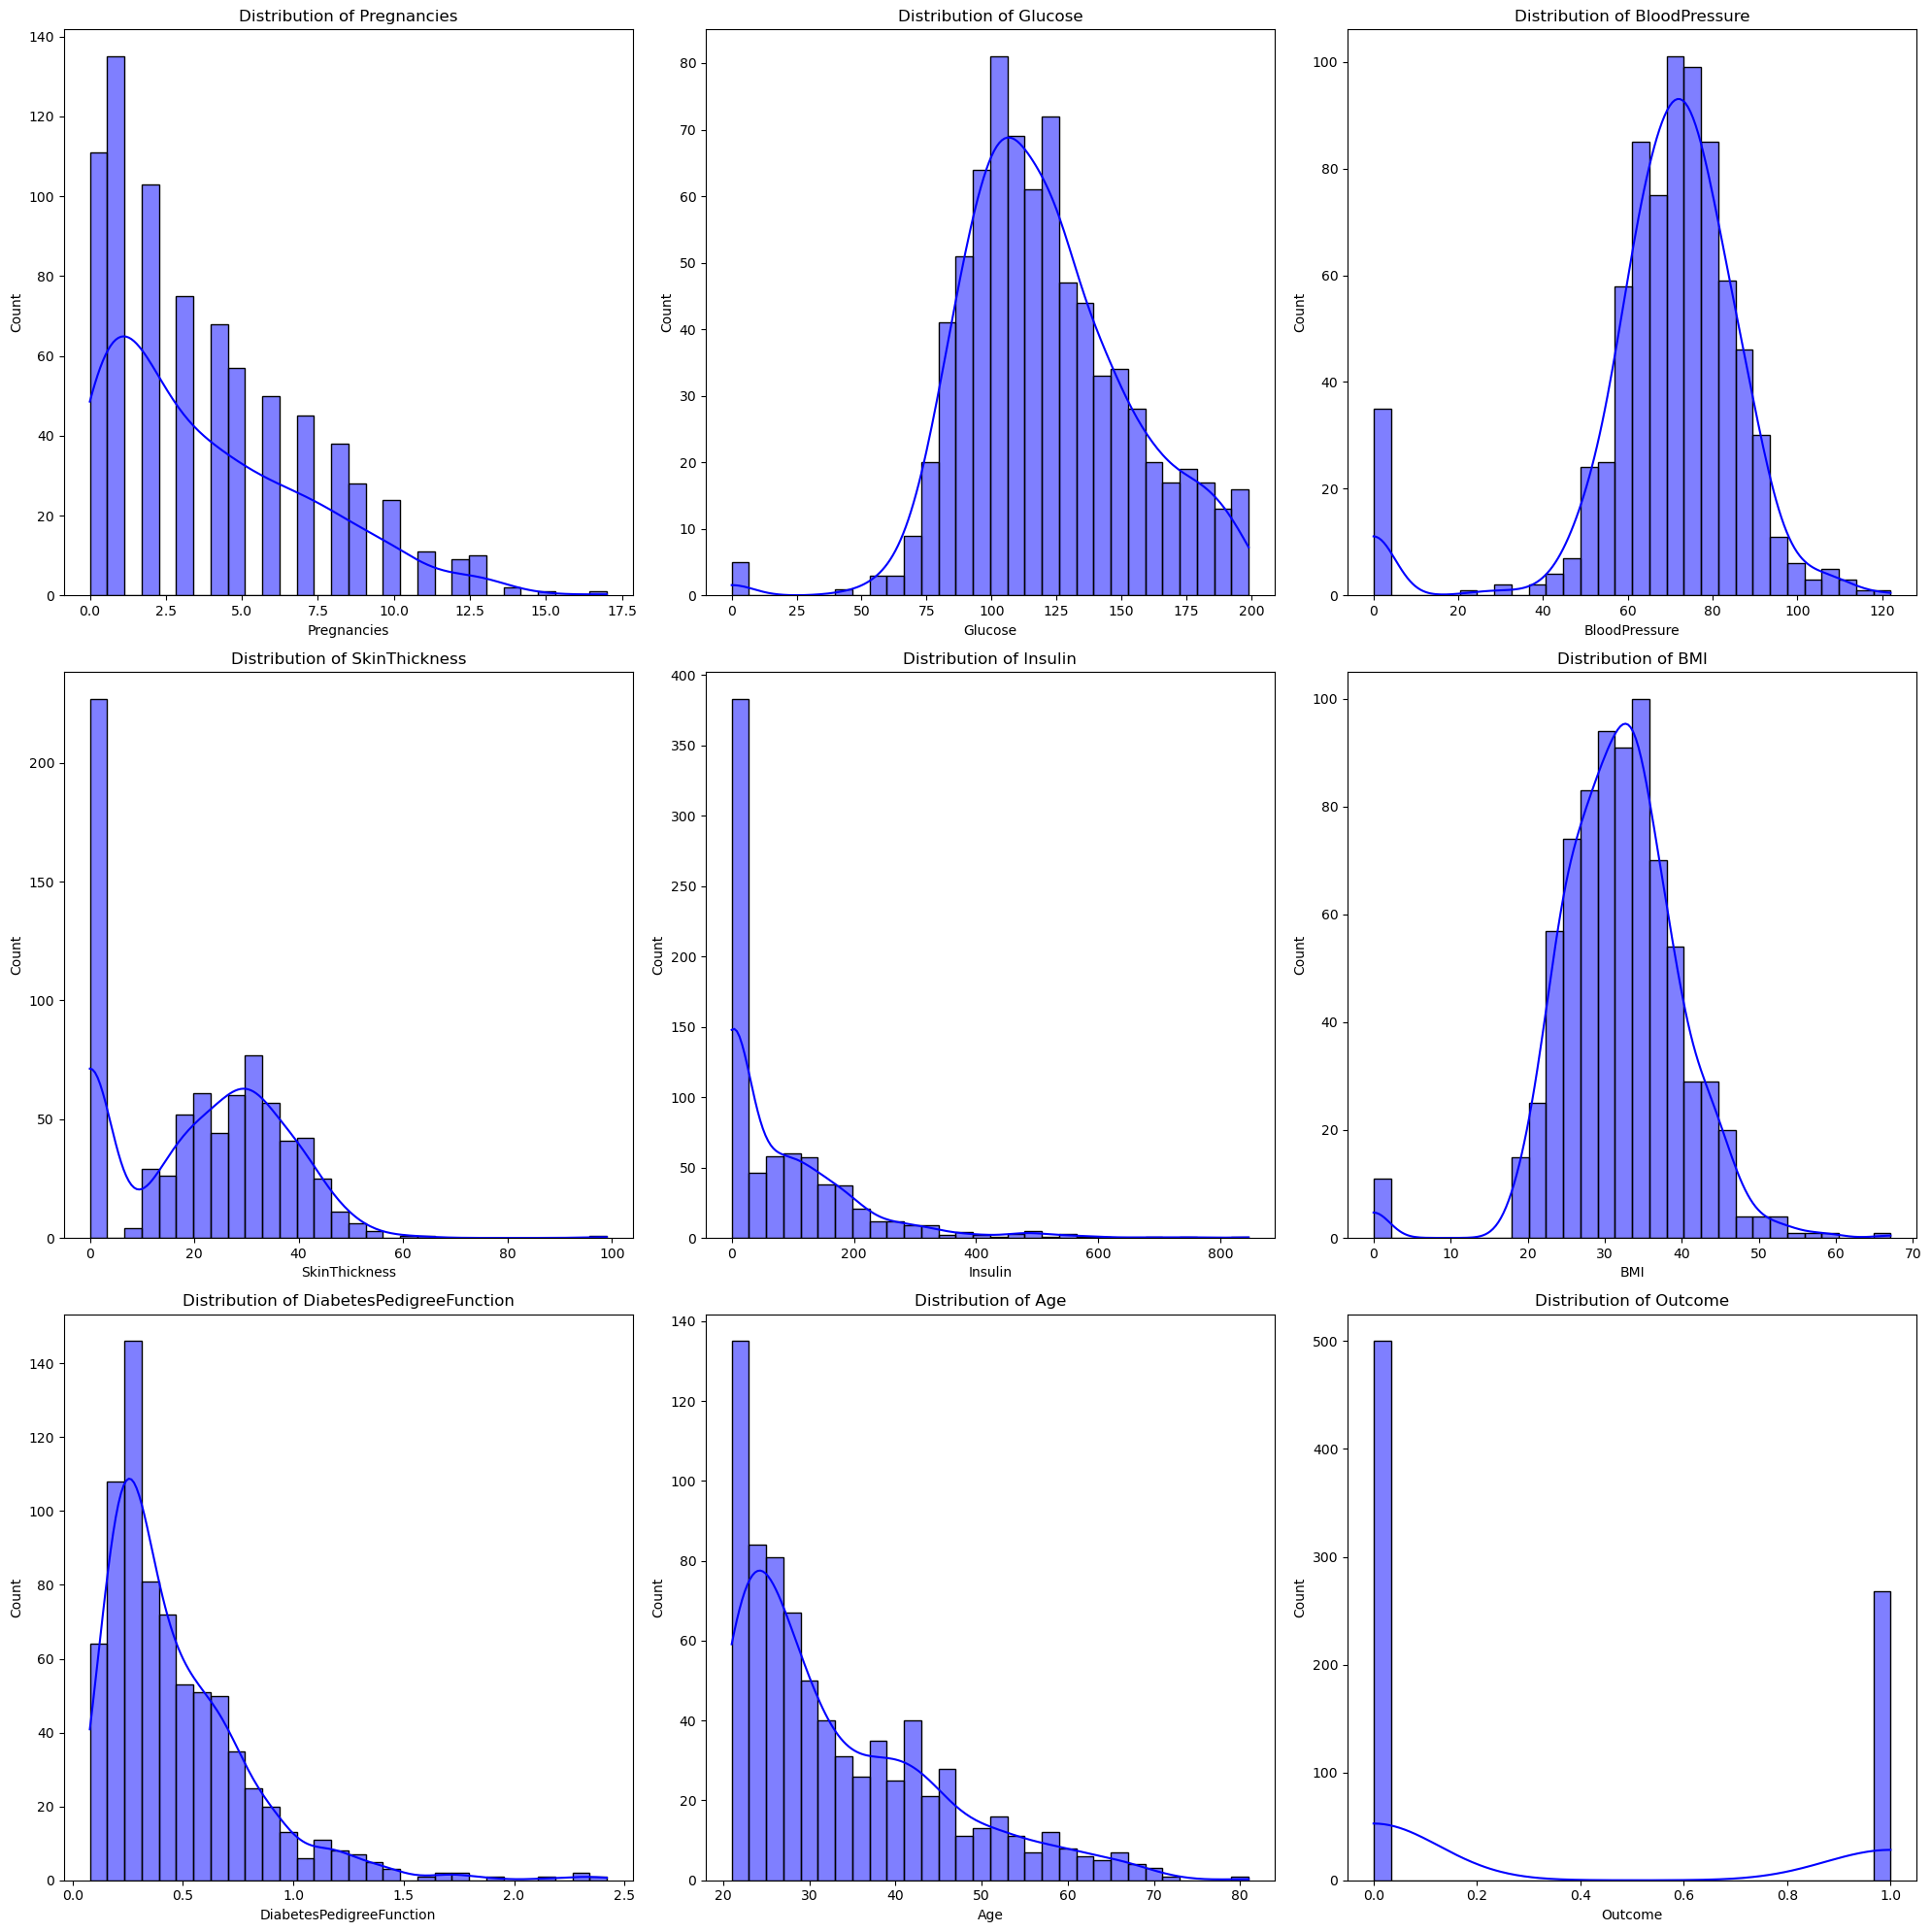

In [23]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(data_columns):  
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

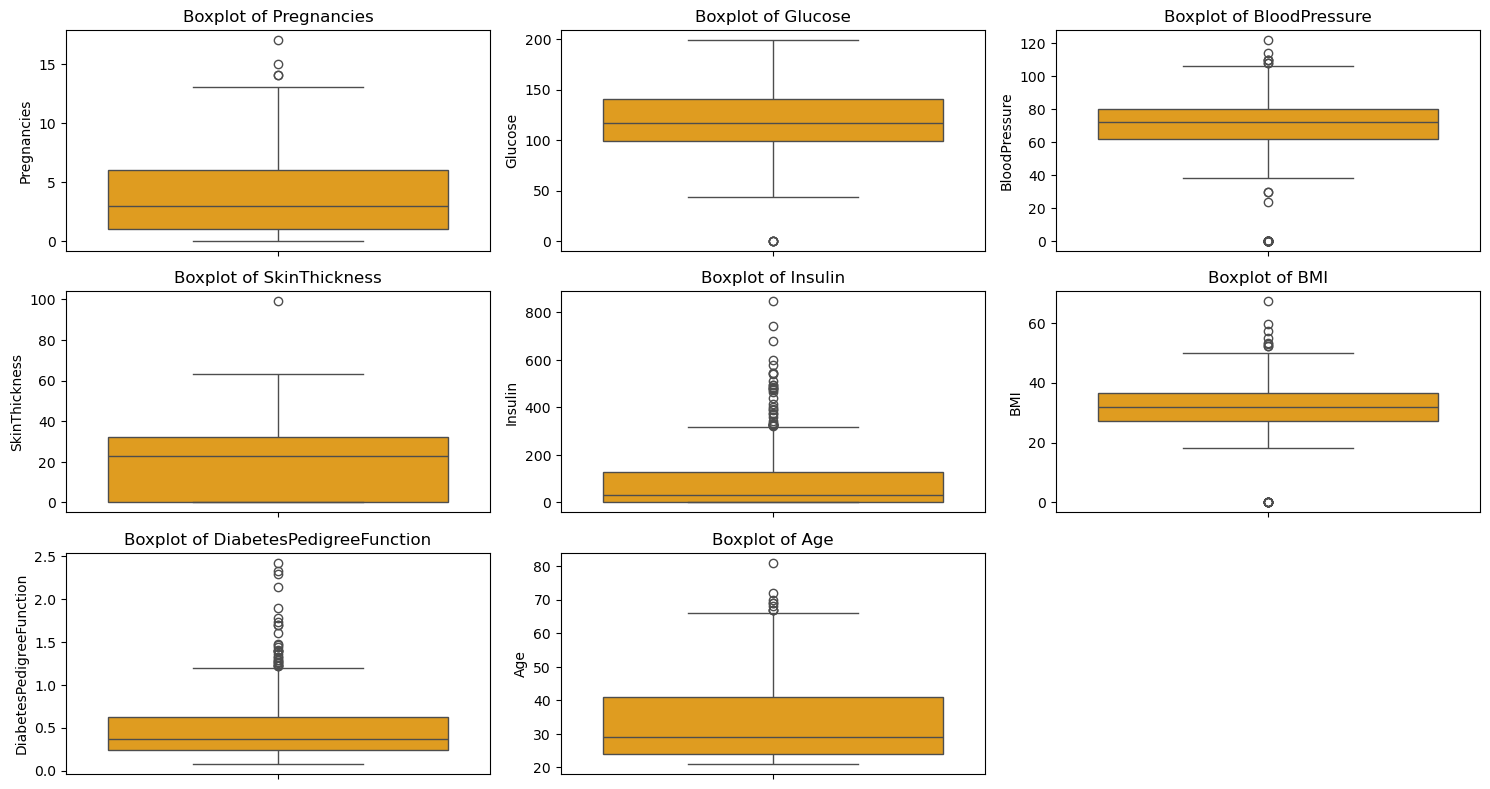

In [24]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(data_columns[:-1]):  
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

However, some attributes cannot be zero

### Counting the number of zeros

In [27]:
# Count the number of zeros in each column
zero_counts = (df == 0).sum()

# Get total number of rows in the dataset
total_rows = df.shape[0]

# Calculate the percentage of zeros in each column
zero_percentage = (zero_counts / total_rows) * 100

# Display the results
print("Number of zeros in each column:")
print(zero_counts, "     ", total_rows)

print("\nPercentage of zeros in each column:")
print(zero_percentage)


Number of zeros in each column:
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64       768

Percentage of zeros in each column:
Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                     65.104167
dtype: float64


The number of missing values is very high (more than 20-30%) in that column, so we do not replace it with mean or median

# 3. Further Cleaning

### Create new file

In [31]:
df_cleaned = df.copy()

### Remove row where any of the columns have abnormal zero values

In [33]:
columns_to_remove_zeros = ["BloodPressure", "BMI", "Glucose"]
df_cleaned = df_cleaned[~(df_cleaned[columns_to_remove_zeros] == 0).any(axis=1)]

### Save the cleaned file

In [35]:
df_cleaned.to_csv("diabetes_no_zeros.csv", index=False)
data_columns = df_cleaned.columns

### Revisualize

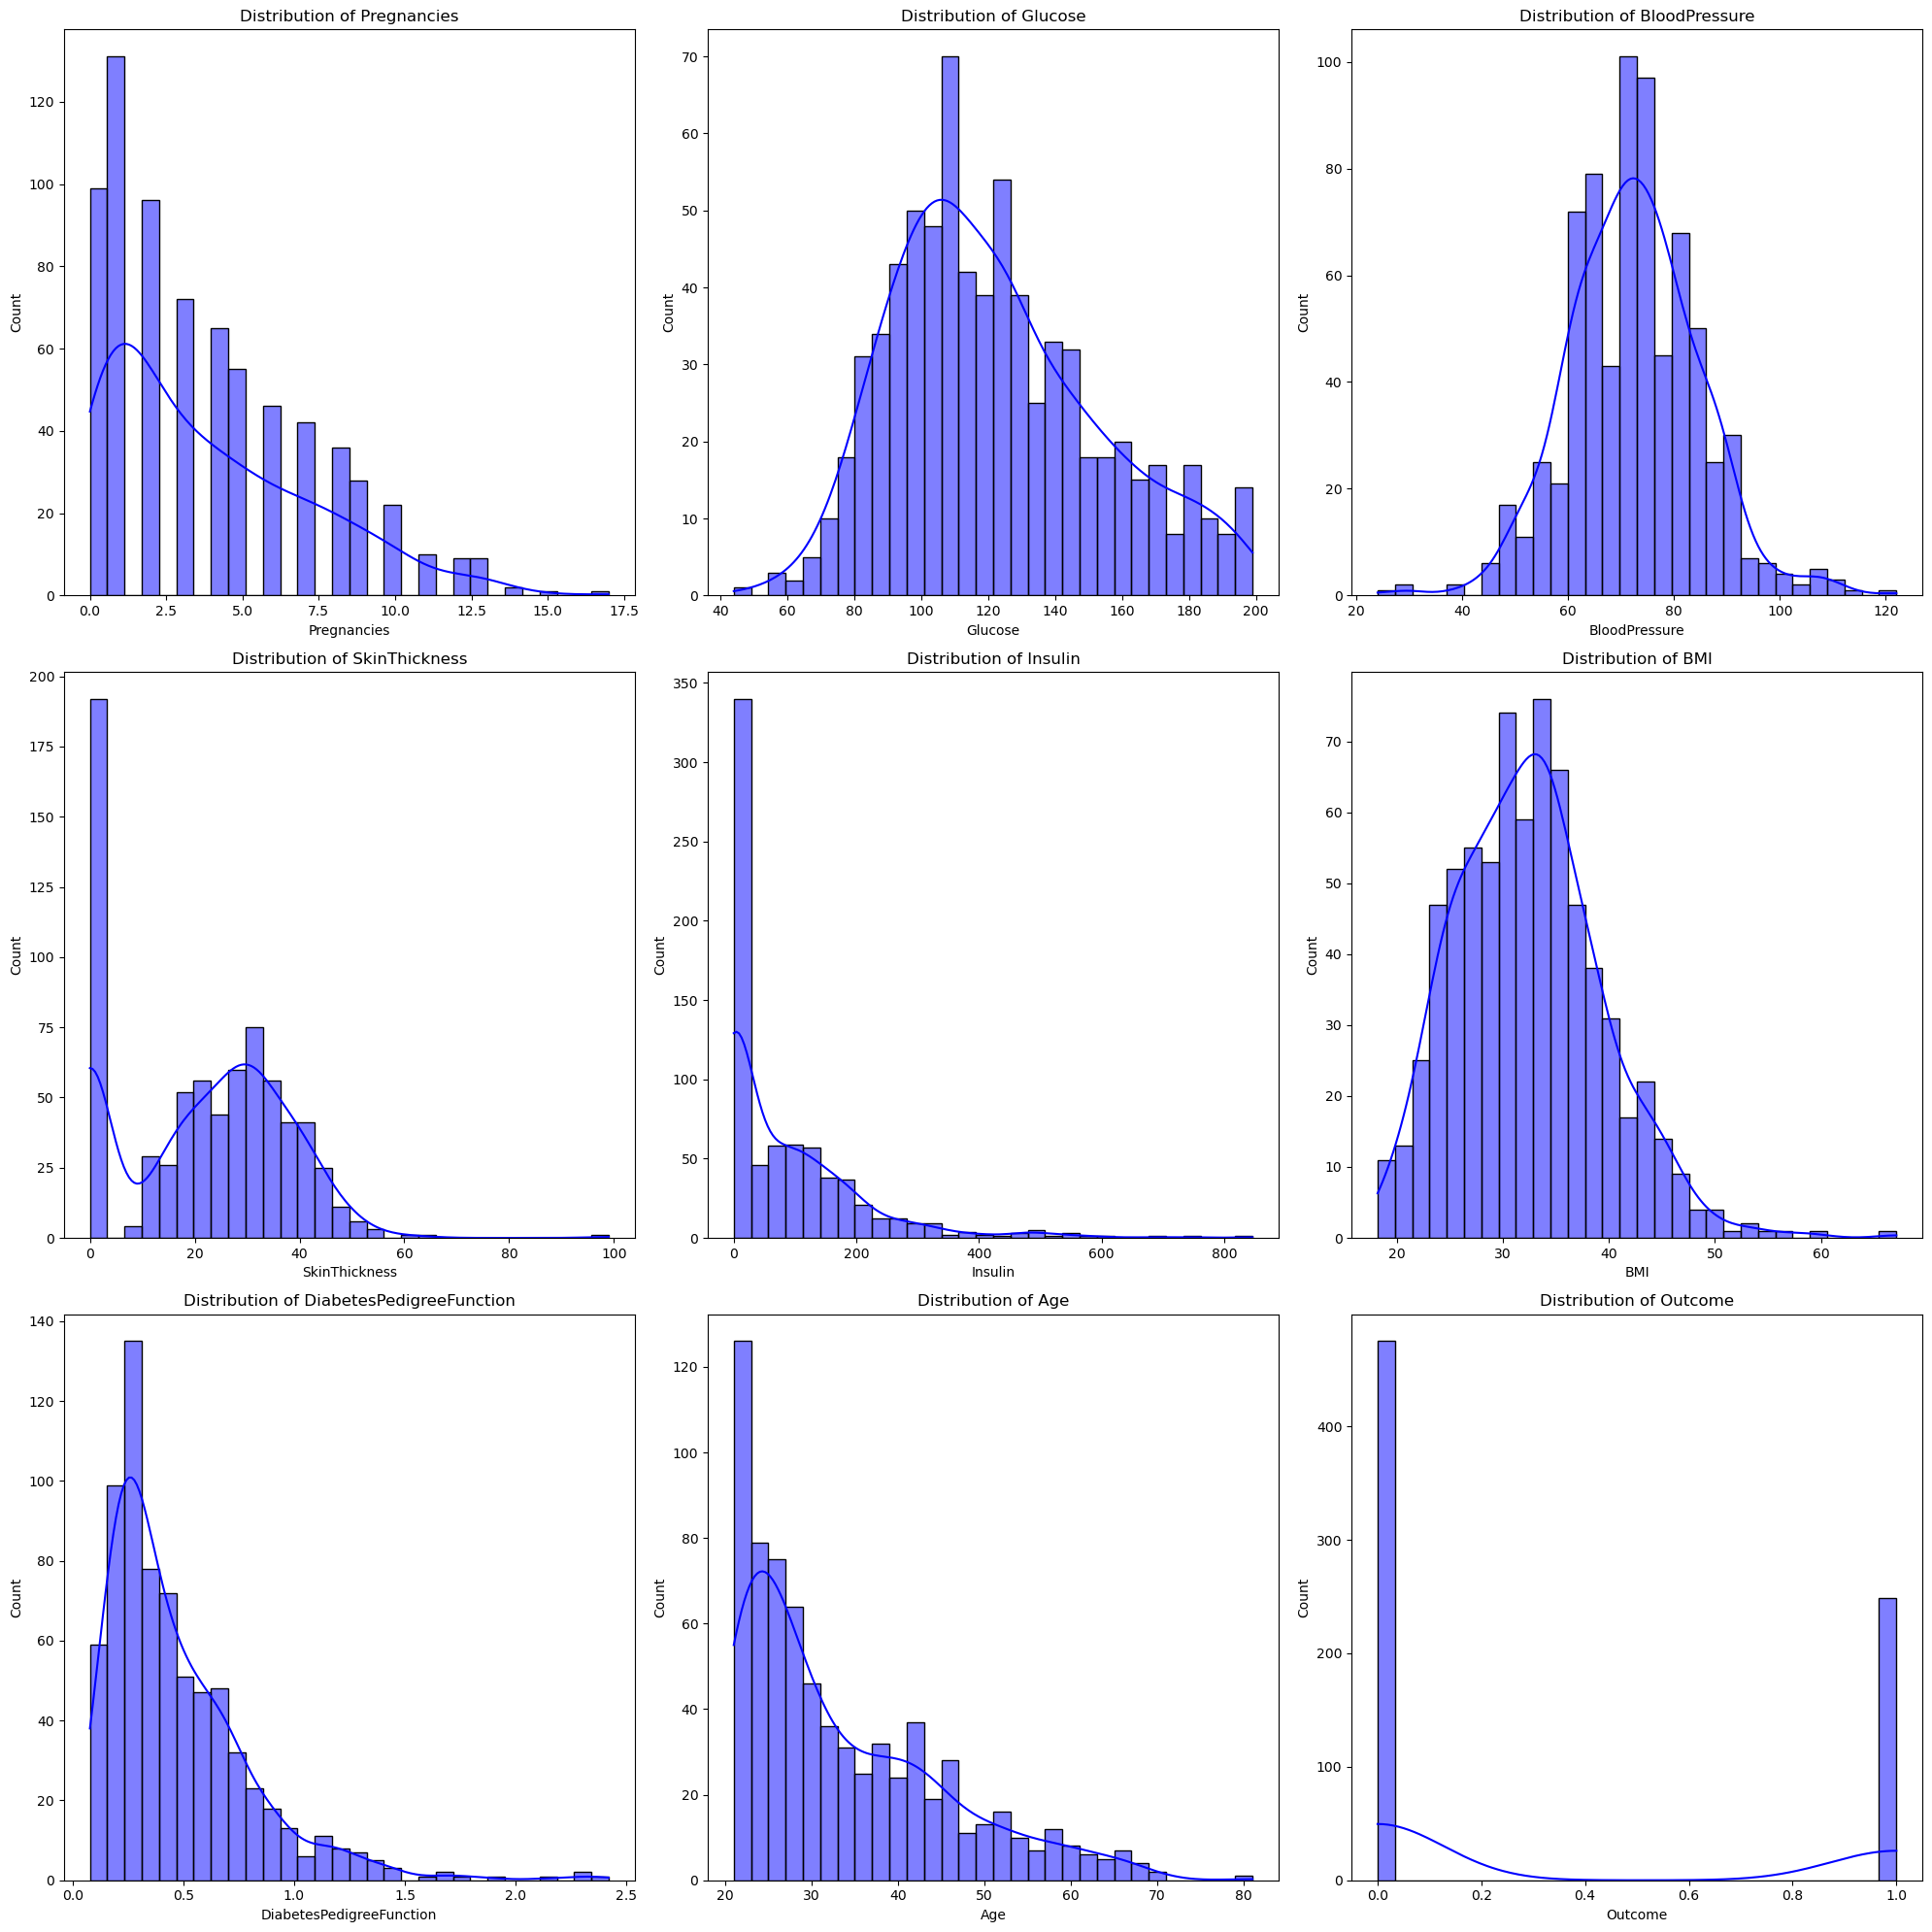

In [37]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(data_columns):  
    plt.subplot(3, 3, i+1)
    sns.histplot(df_cleaned[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

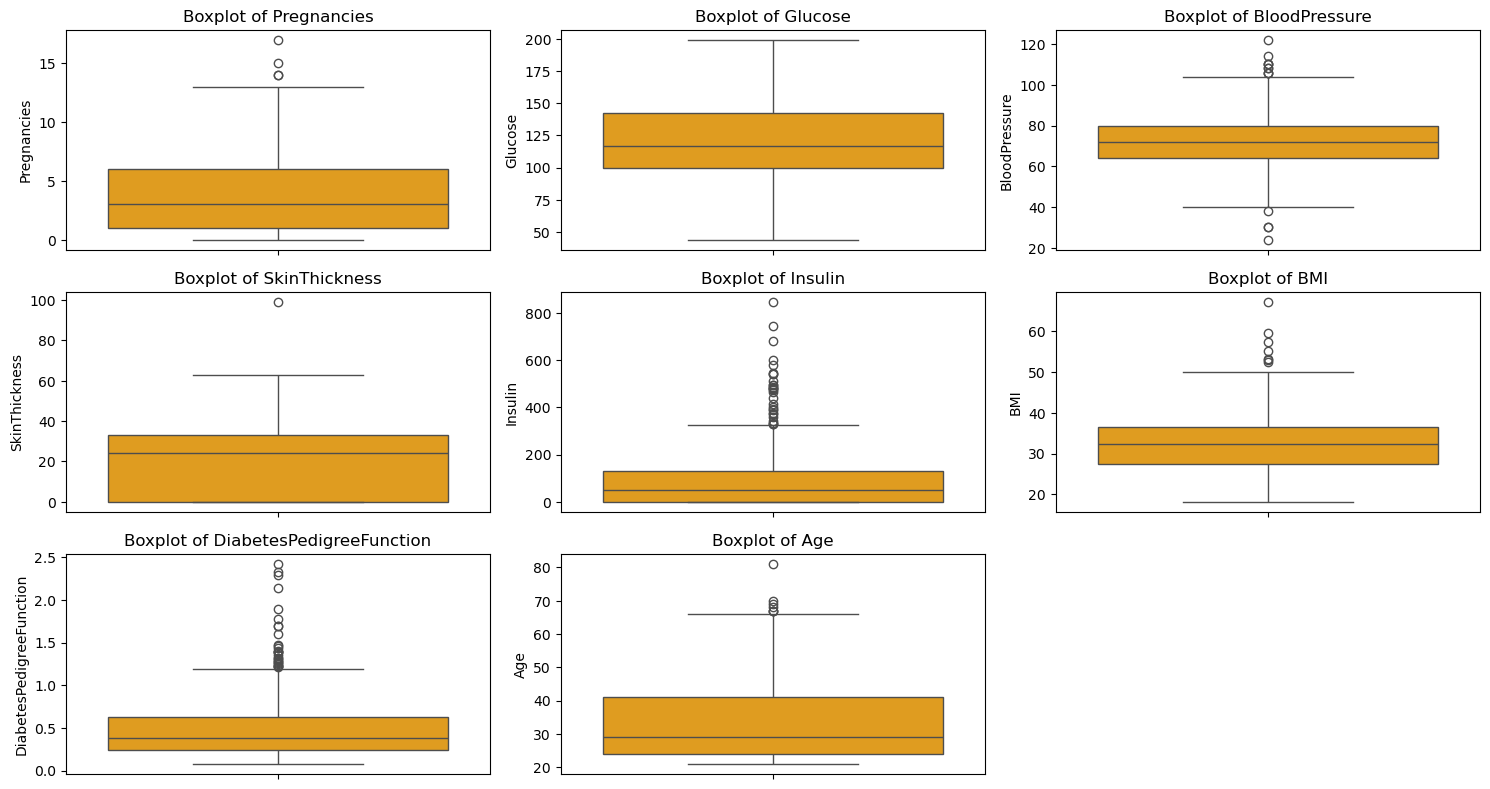

In [38]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(data_columns[:-1]):  
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df_cleaned[col], color="orange")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

Scatter matrix of cleaned data

<Figure size 2500x2500 with 0 Axes>

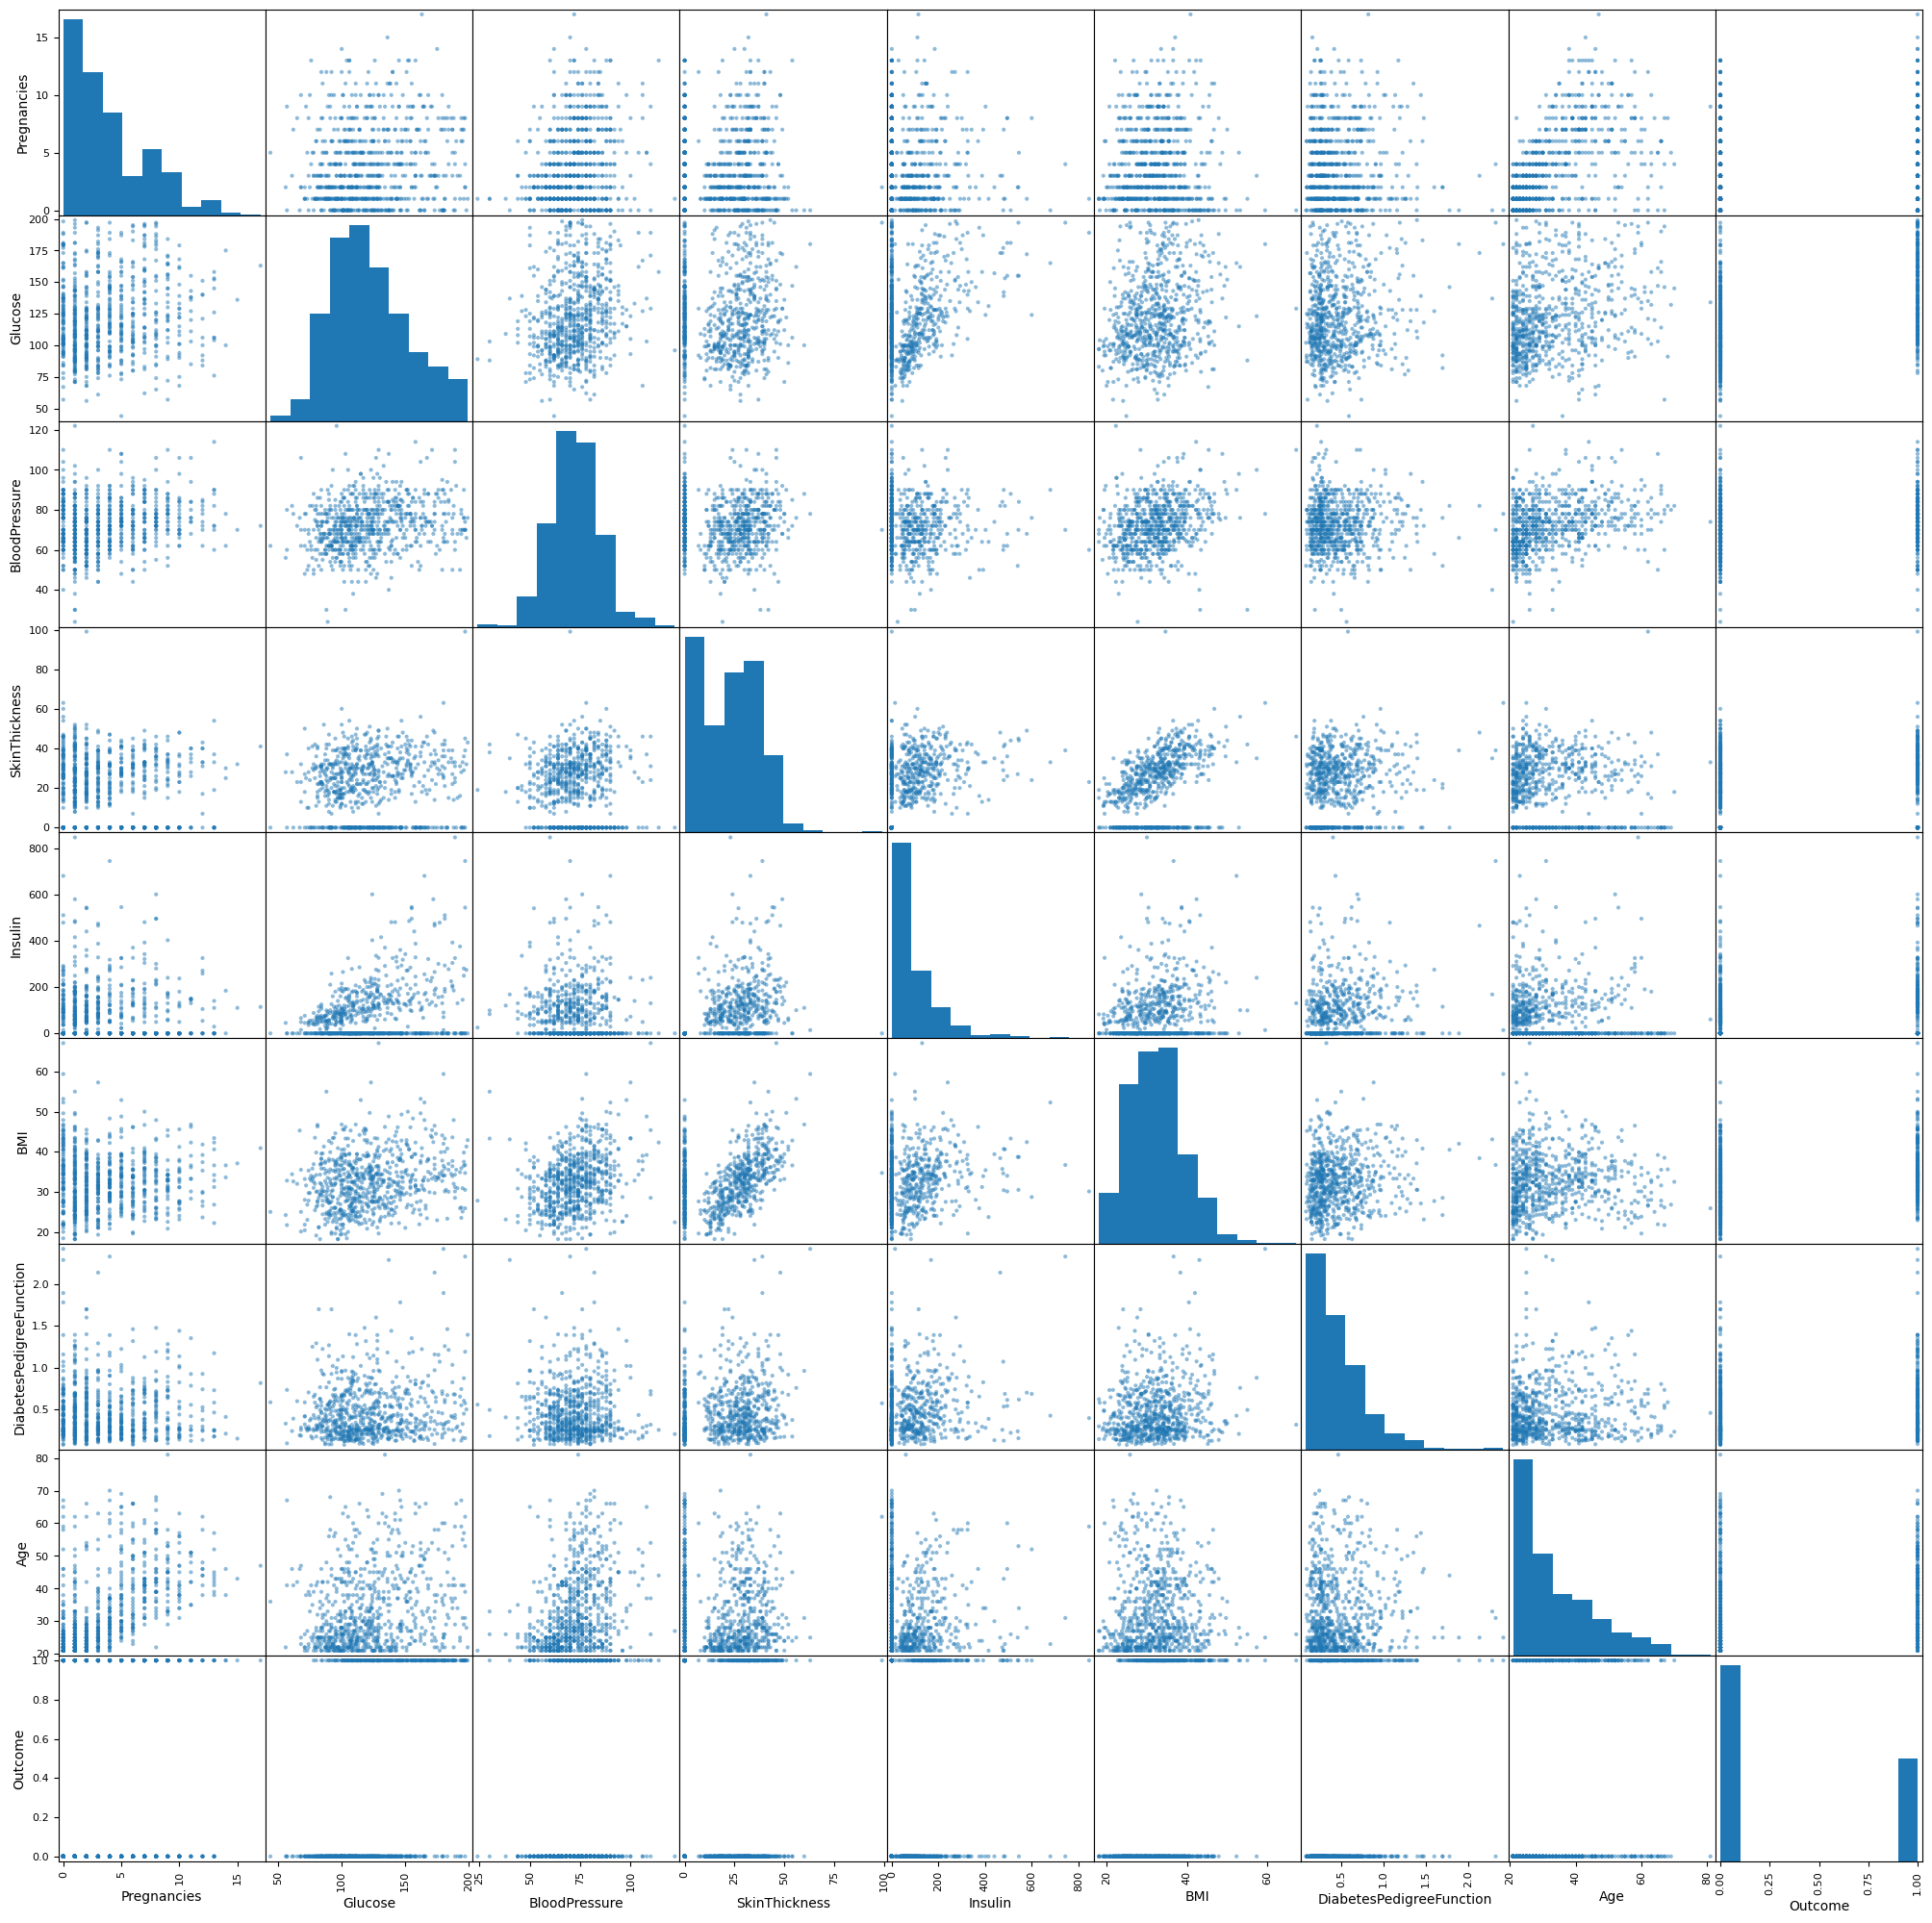

In [40]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Generate the scatter matrix plot
plt.figure(figsize=(25, 25))
scatter_matrix(df_cleaned, figsize=(25, 25))
plt.show()


Pair plot for cleaned data

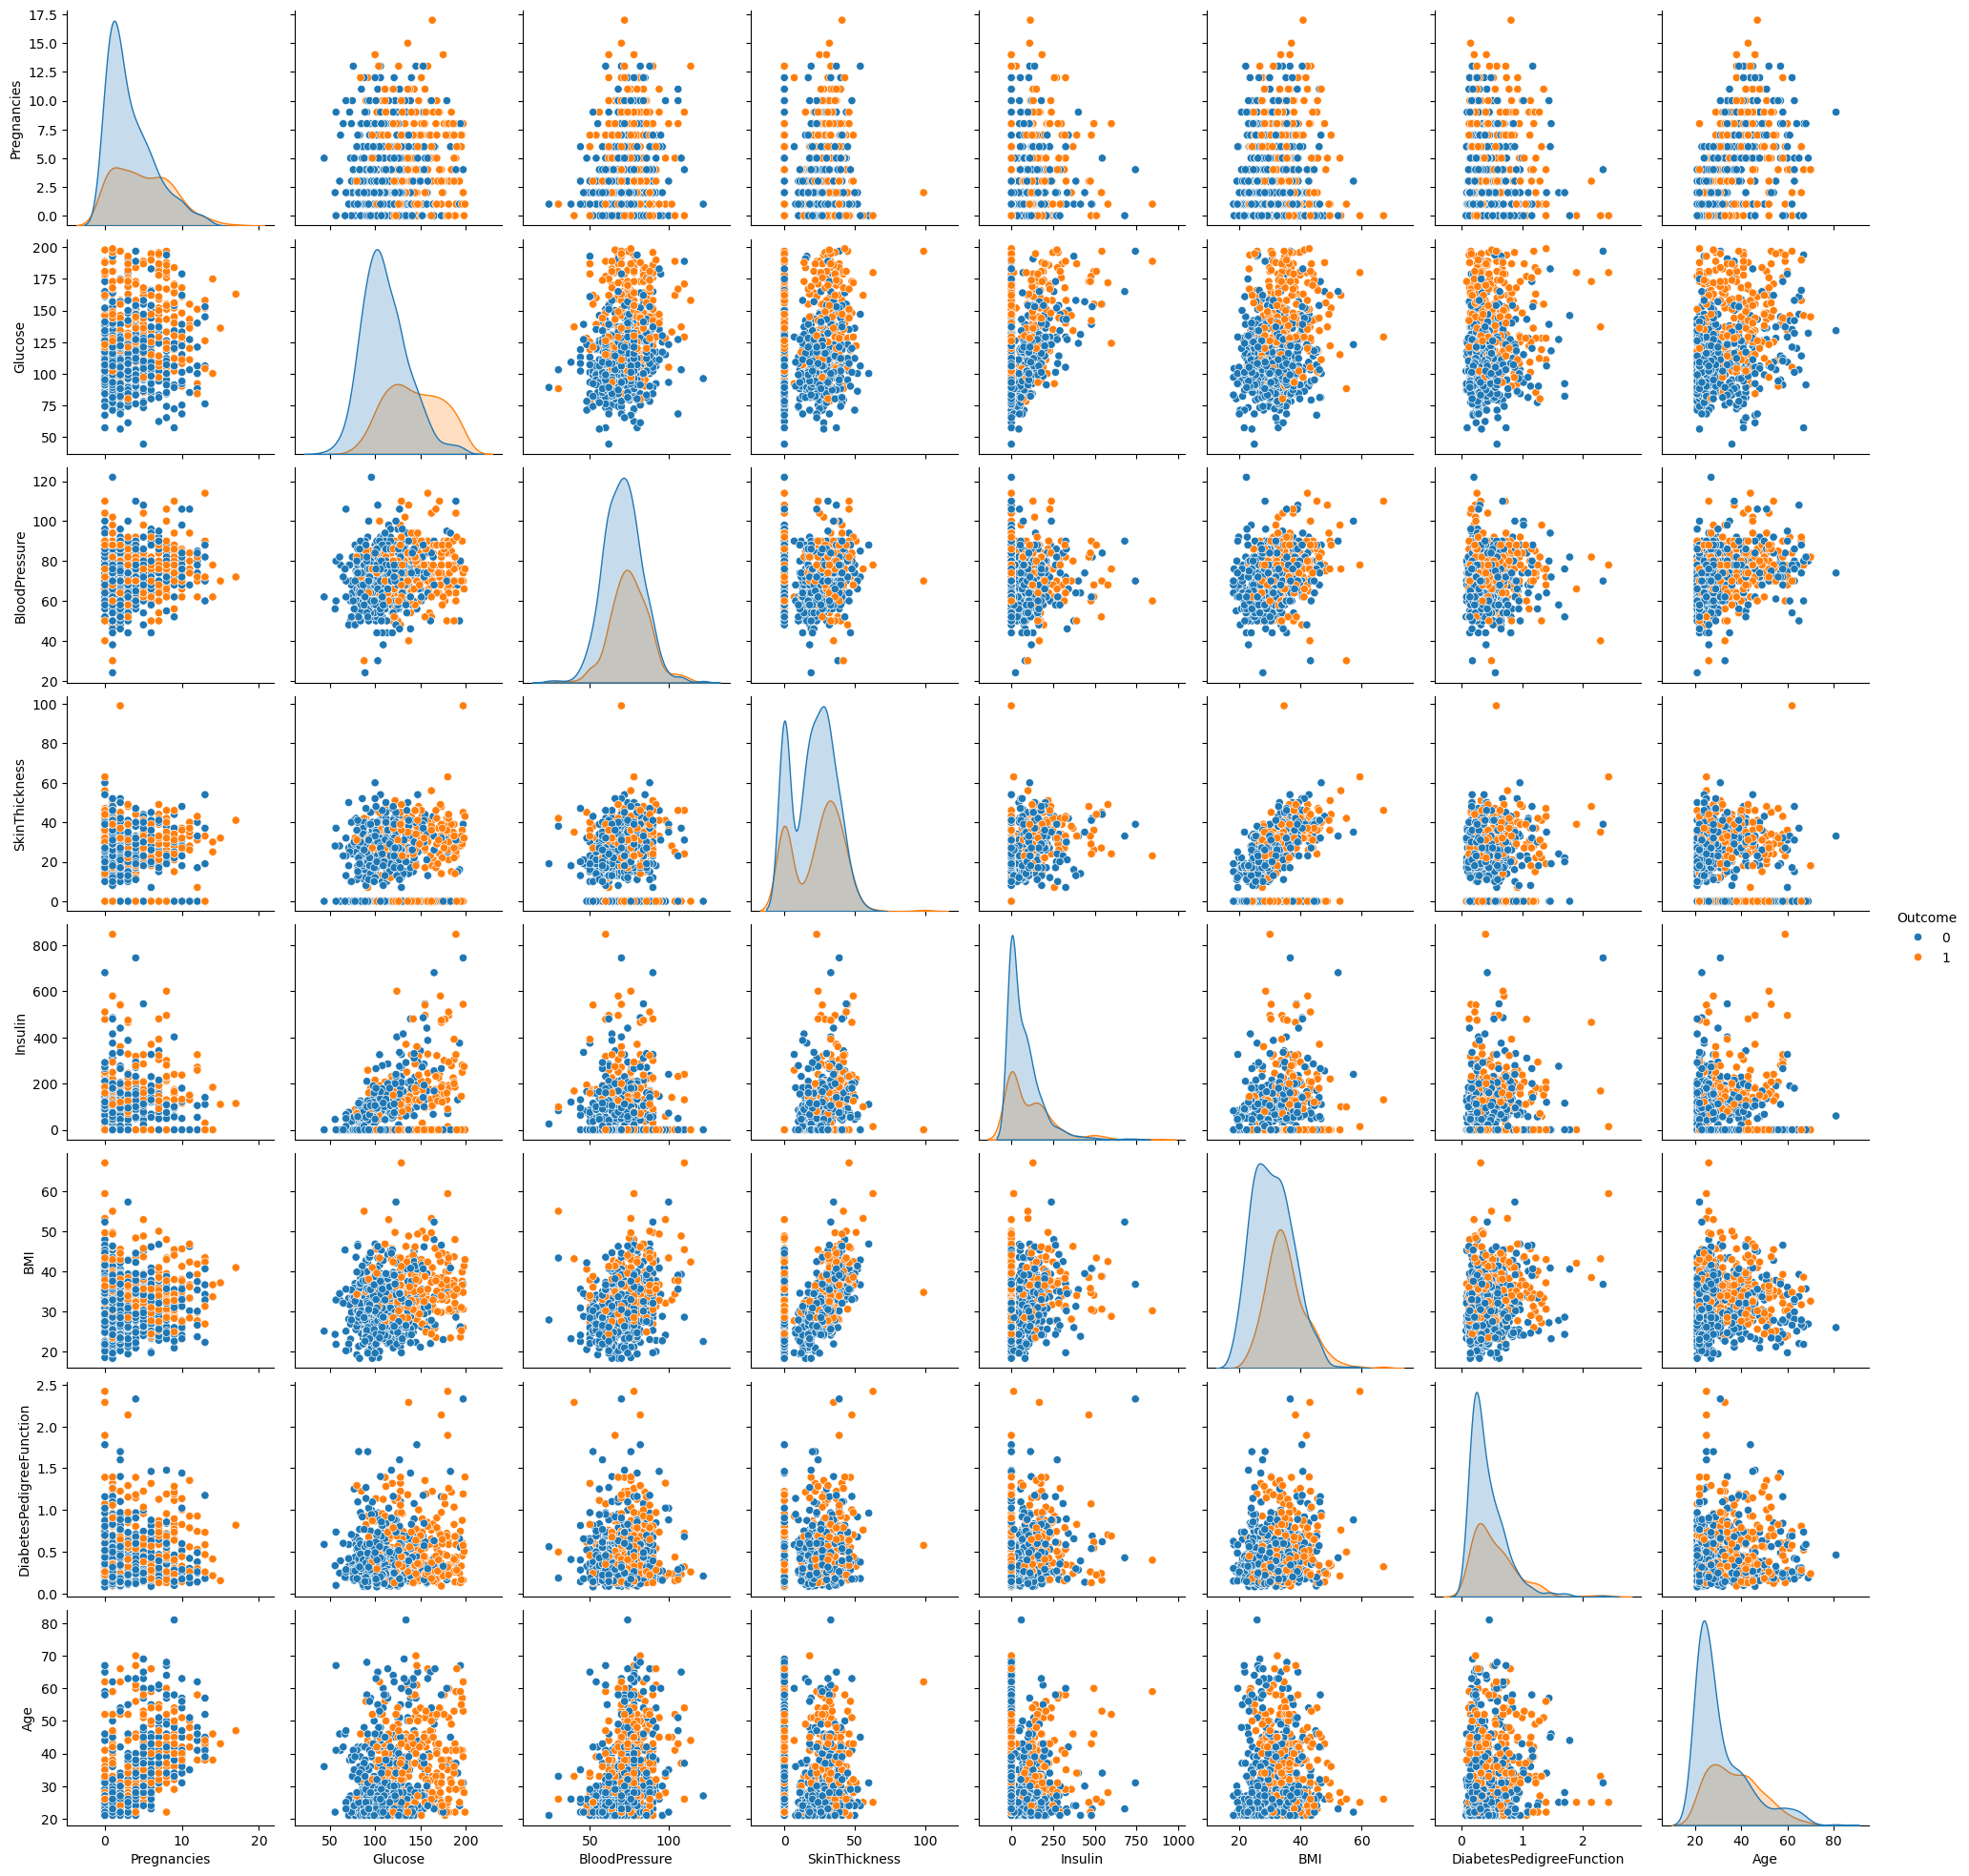

In [42]:
p=sns.pairplot(df_cleaned, hue = 'Outcome')

Heatmap for cleaned data

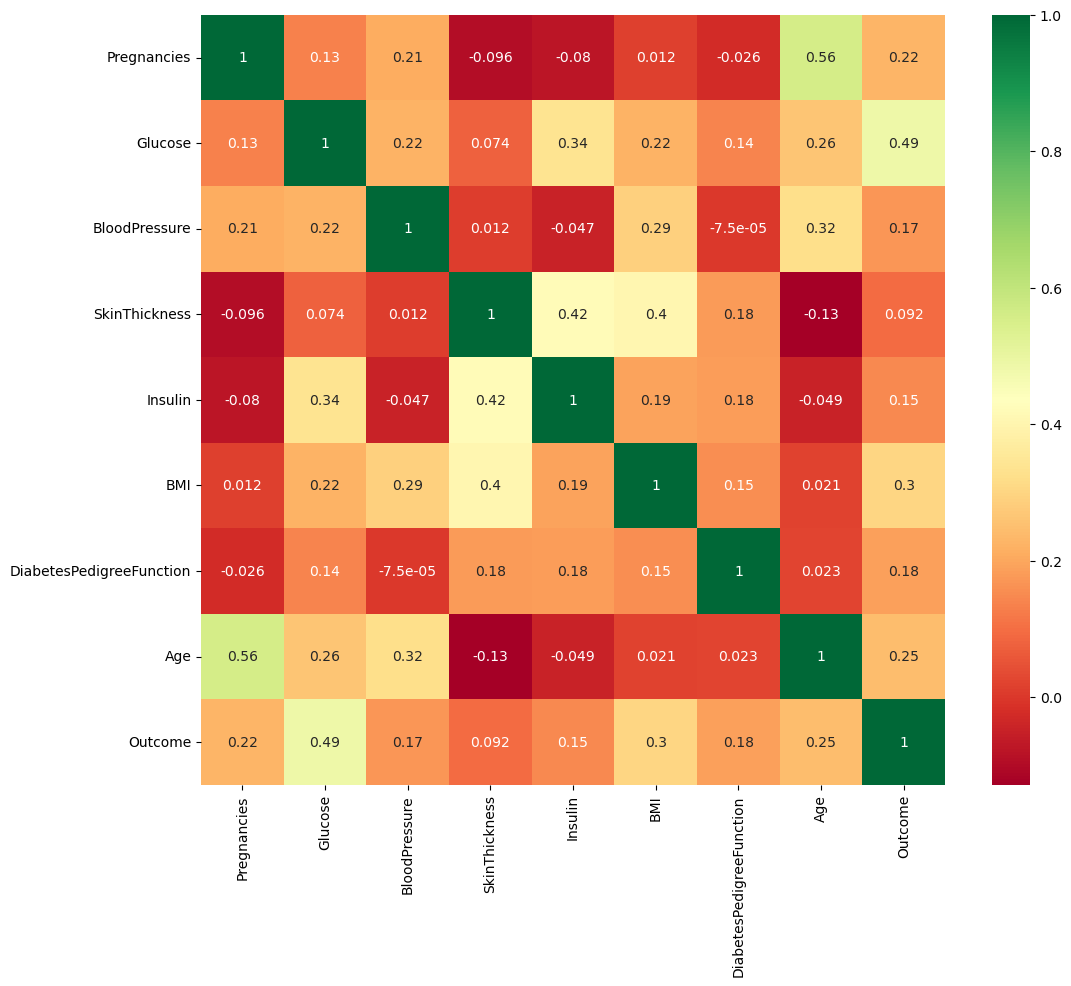

In [44]:
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df_cleaned.corr(), annot=True,cmap ='RdYlGn')

# Remove SkinThickness Feature

### Load the diabetes dataset

In [47]:
# Load the CSV file
file_path = "diabetes_no_zeros.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

### Remove SkinThickness column

In [49]:
if 'SkinThickness' in df.columns:
    df = df.drop(columns=['SkinThickness'])

# Save the modified dataframe to a new CSV file
new_file_path = "diabetes_no_SkinThickness.csv"
df.to_csv(new_file_path, index=False)

print(f"Modified CSV saved as {new_file_path}")

Modified CSV saved as diabetes_no_SkinThickness.csv


### Revisualize

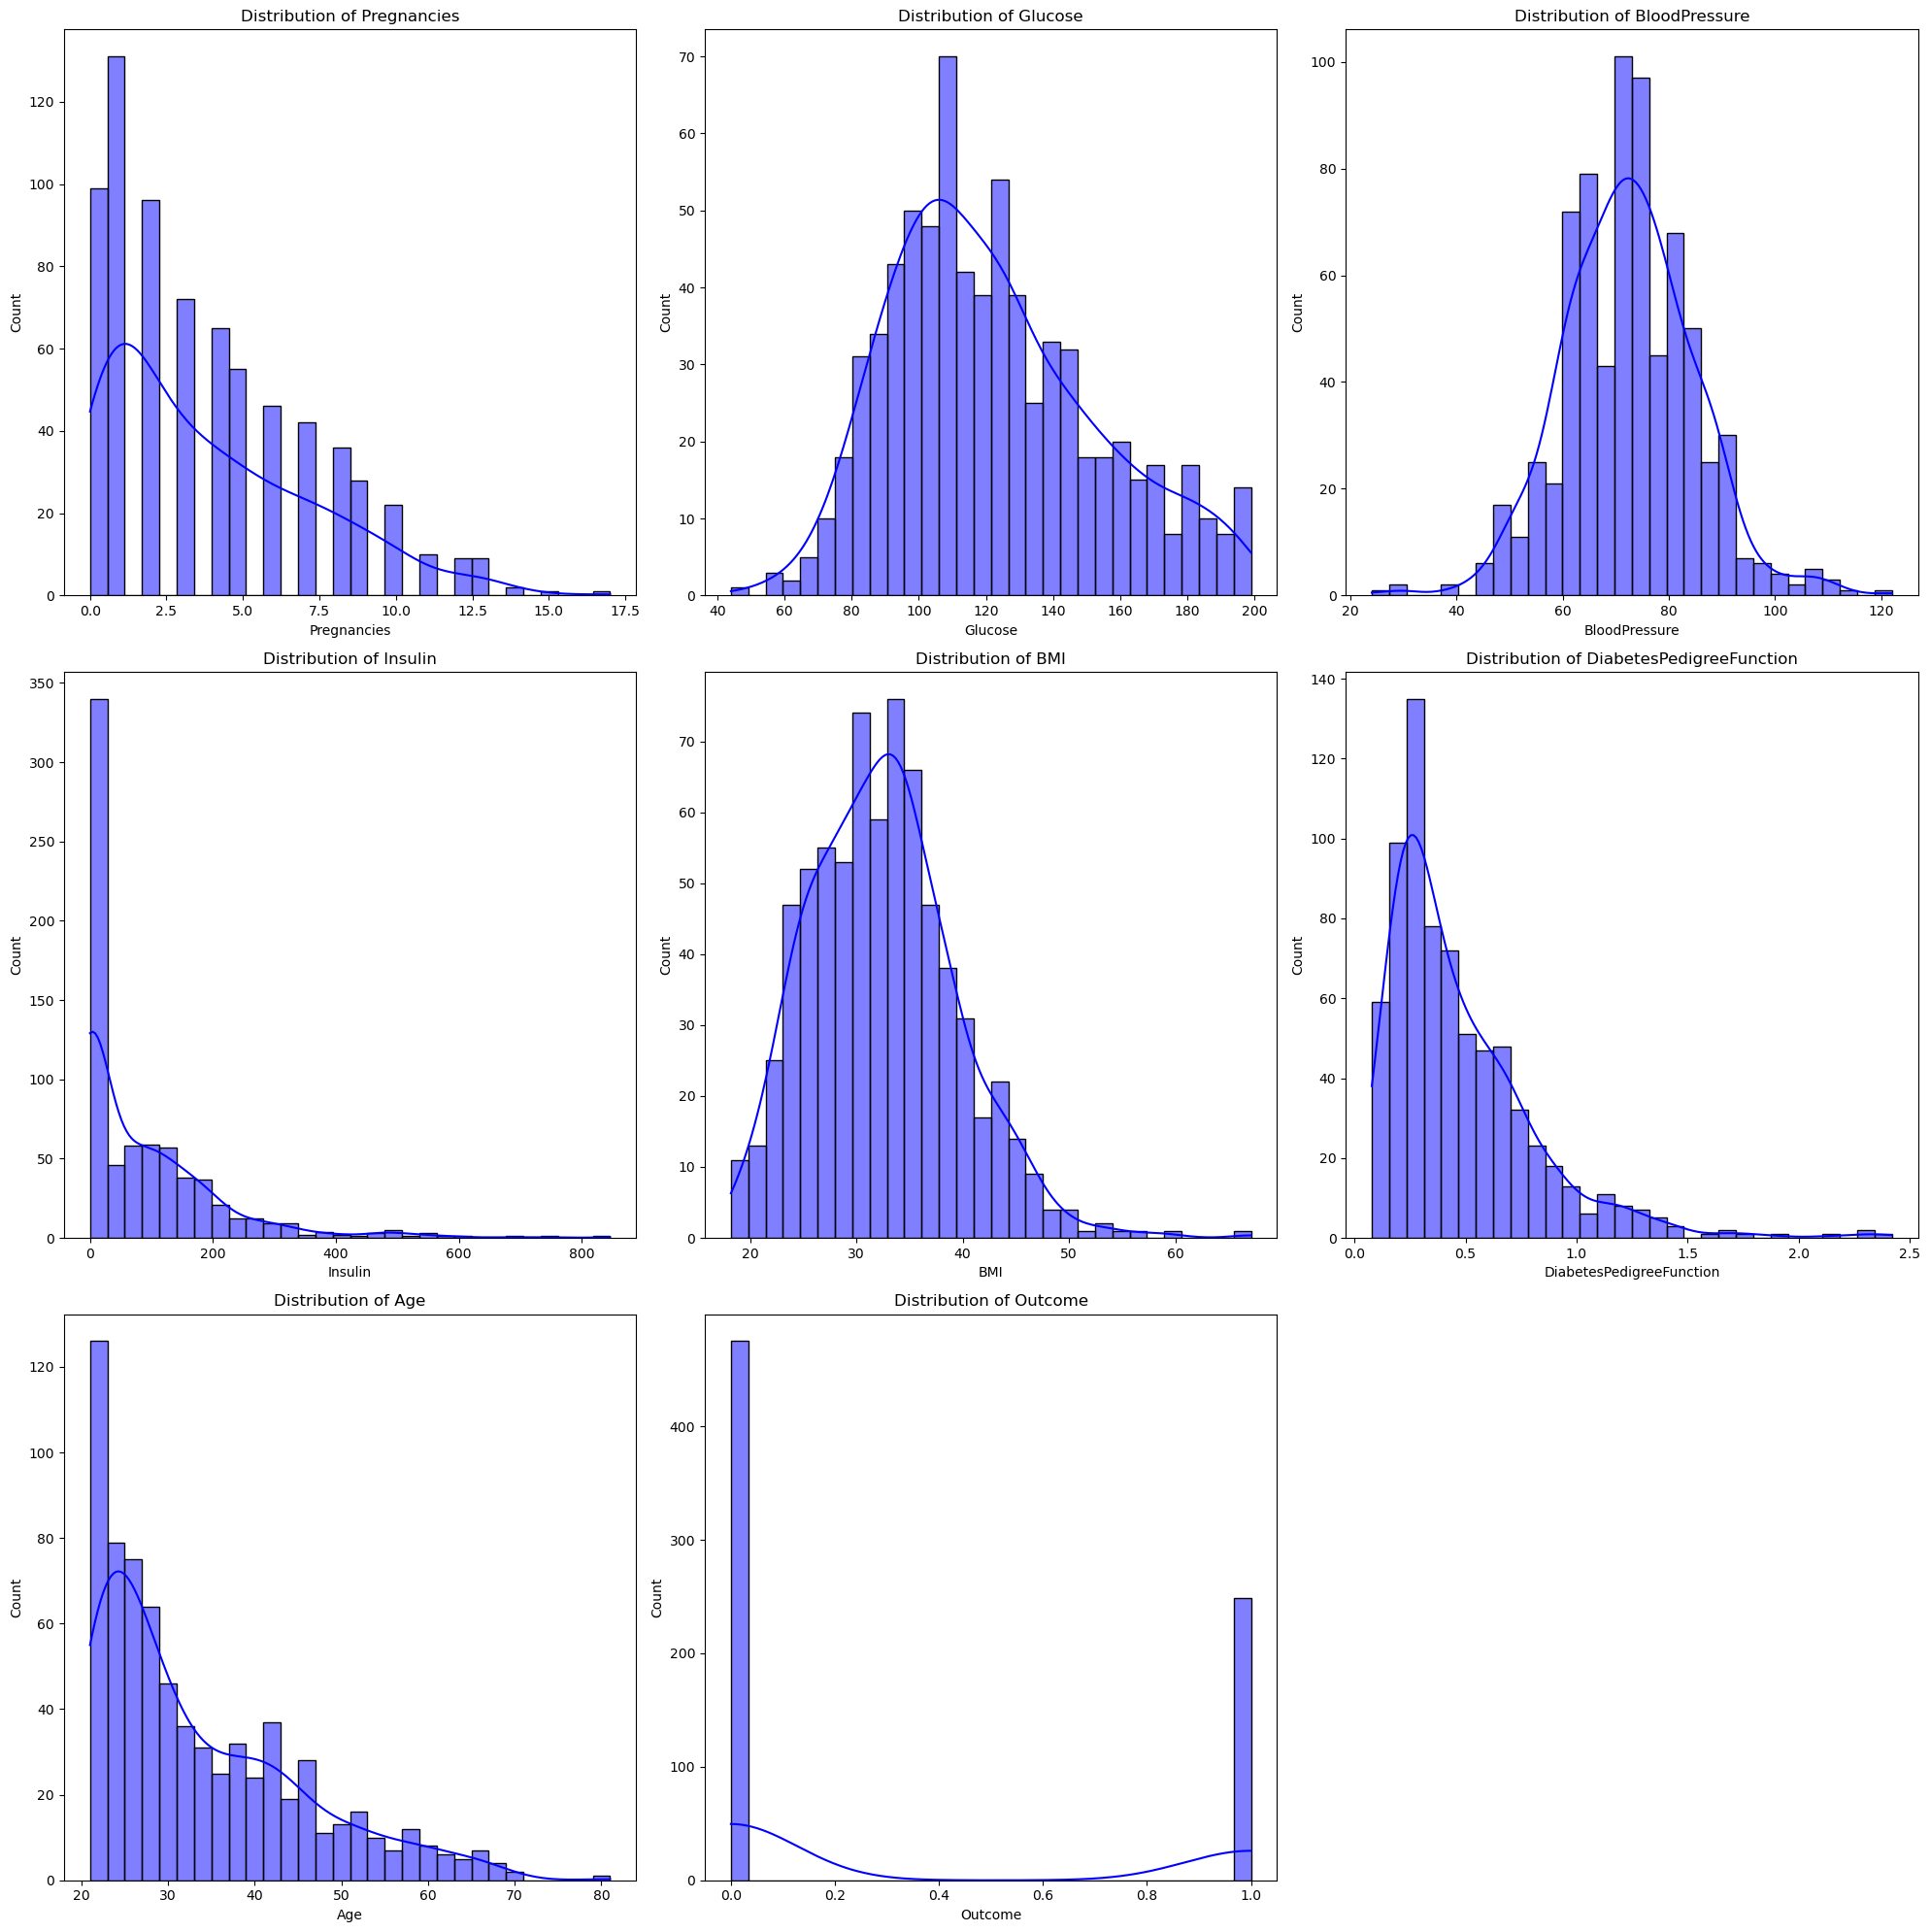

In [51]:
data_columns = df.columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(data_columns):  
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Remove data with zero SkinThickness

### Load the diabetes dataset

In [54]:
# Load the CSV file
file_path = "diabetes_no_zeros.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

### Remove data with zero SkinThickness 

In [56]:
# Remove rows where 'SkinThickness' is zero
if 'SkinThickness' in df.columns:
    df = df[df['SkinThickness'] != 0]

# Save the modified dataframe to a new CSV file
new_file_path = "diabetes_without_zero_SkinThickness.csv"
df.to_csv(new_file_path, index=False)

print(f"Modified CSV saved as {new_file_path}")

Modified CSV saved as diabetes_without_zero_SkinThickness.csv


### Revisualize

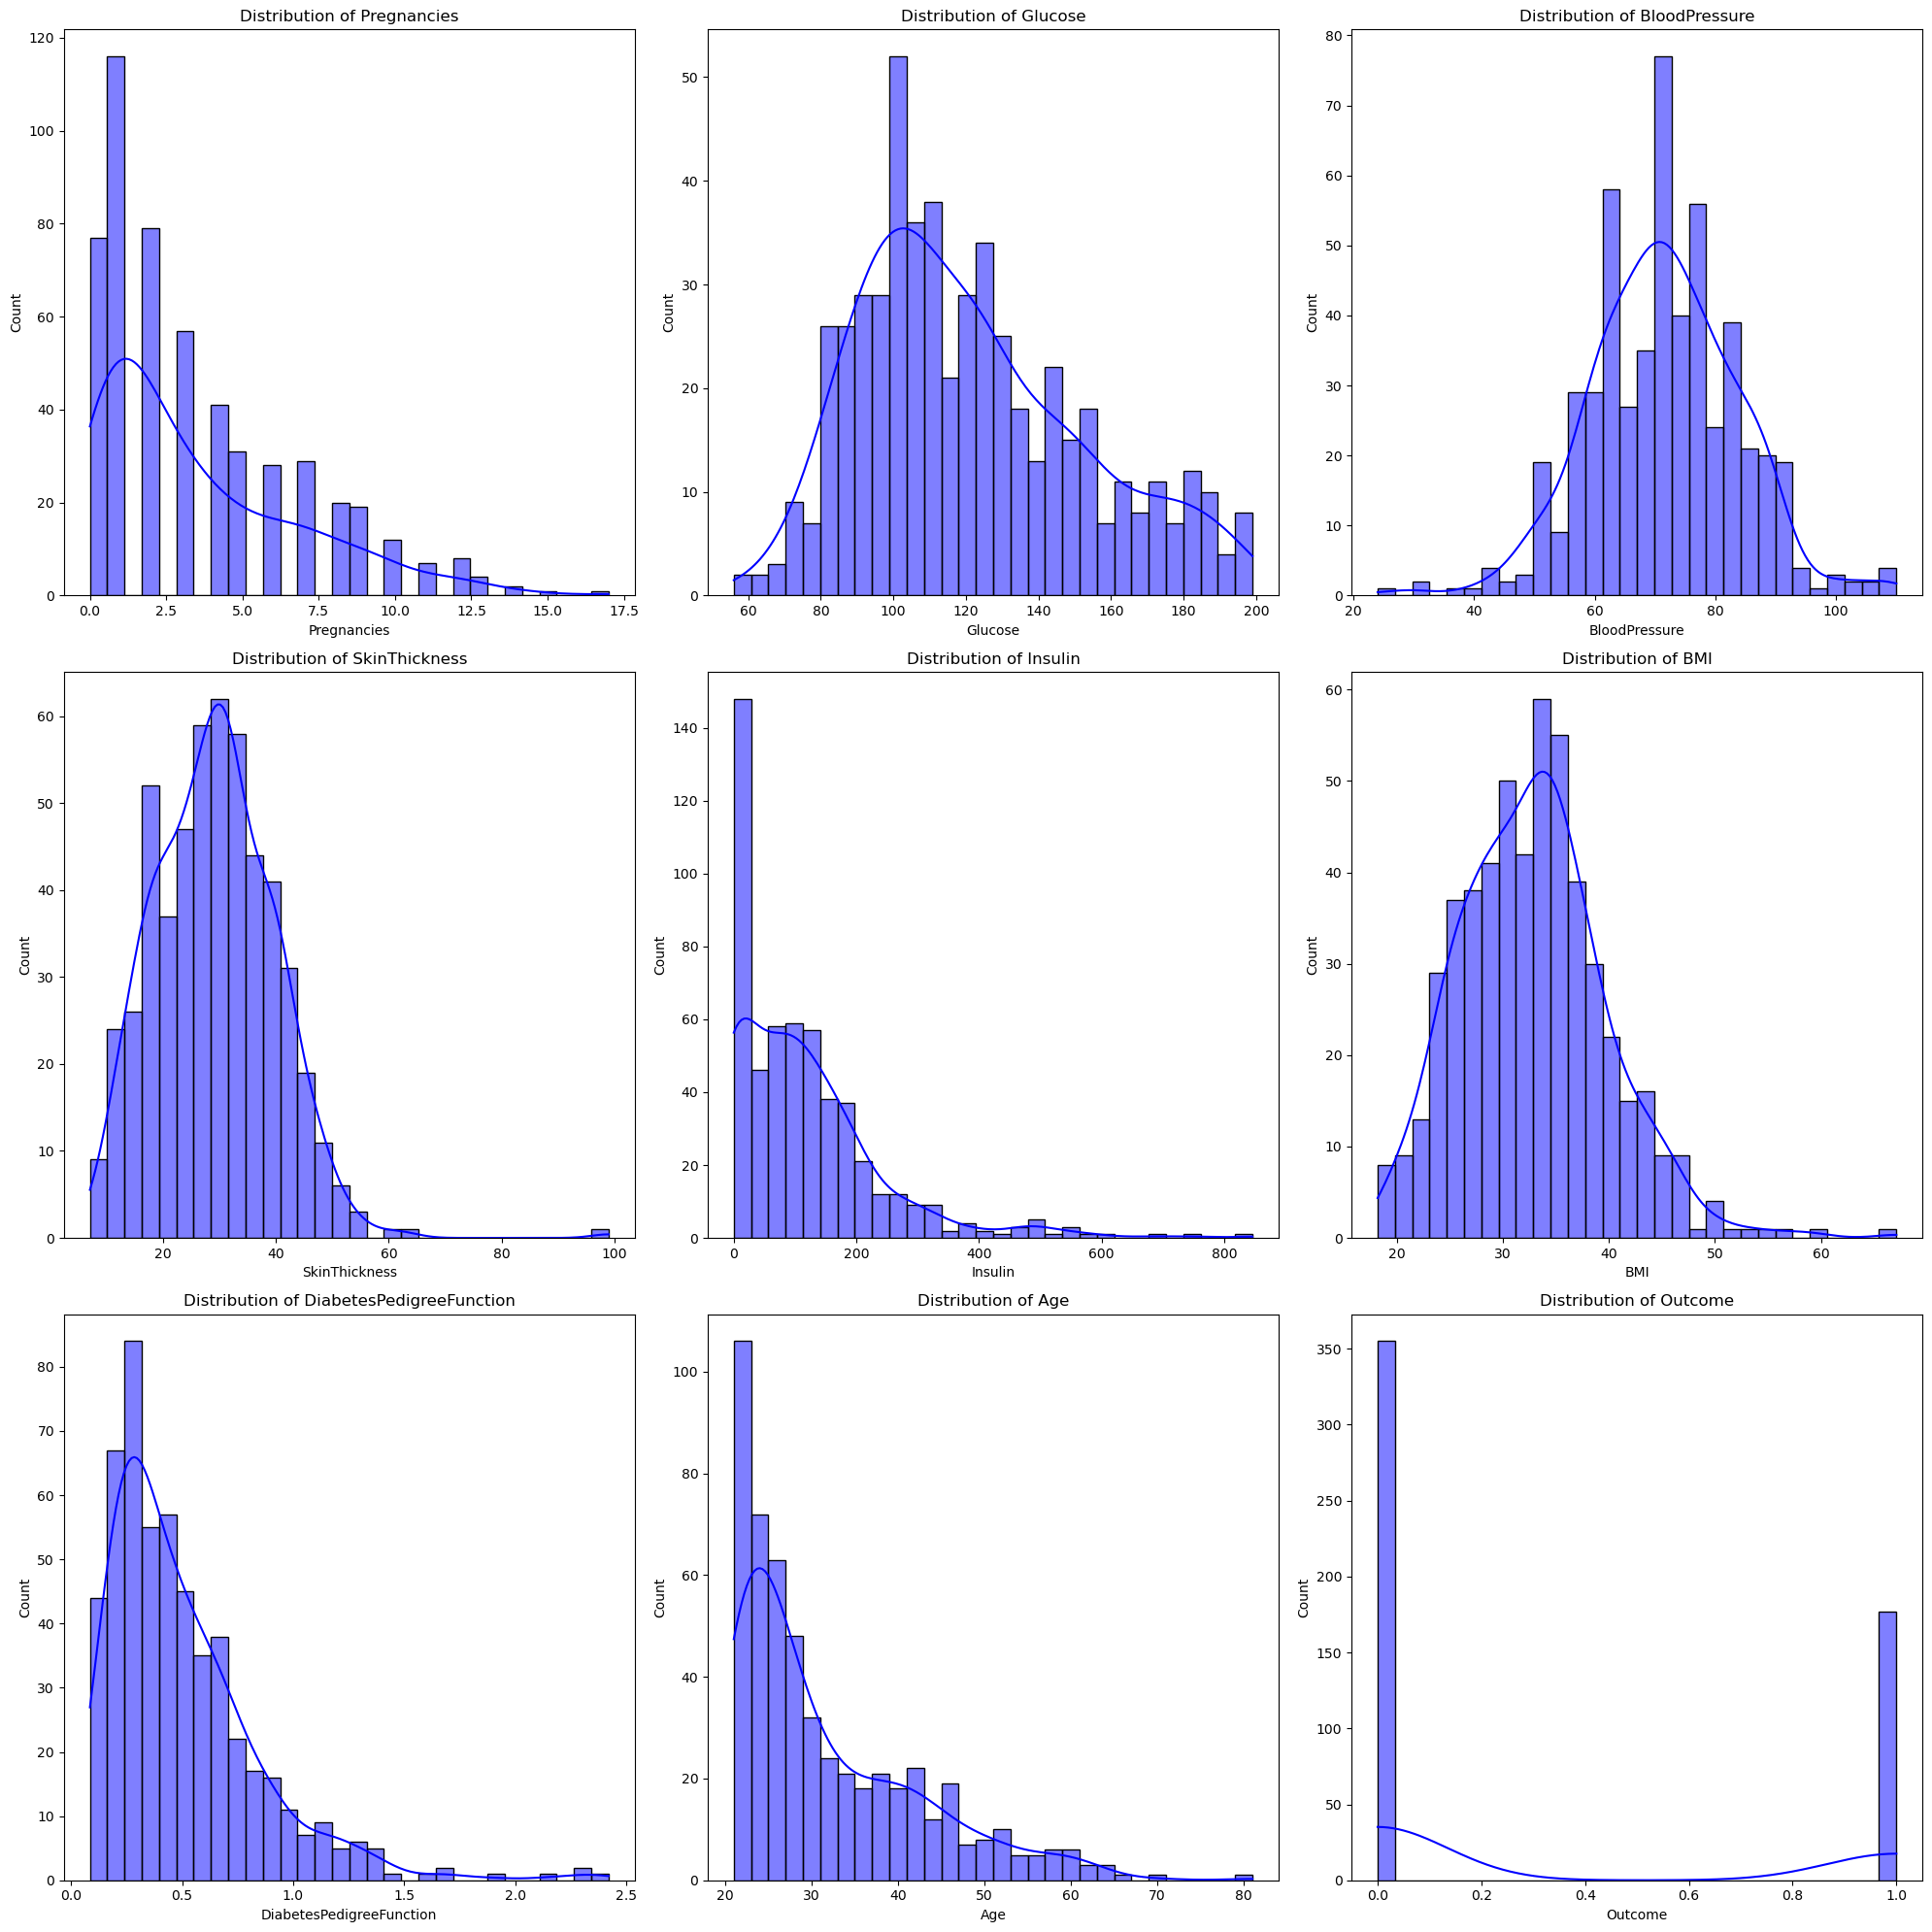

In [58]:
data_columns = df.columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(data_columns):  
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()